# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

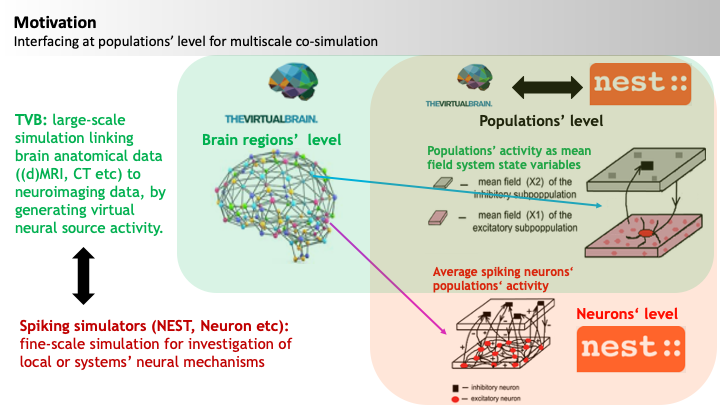

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./pics/ConceptGraph1.png',  width=1000, unconfined=False))

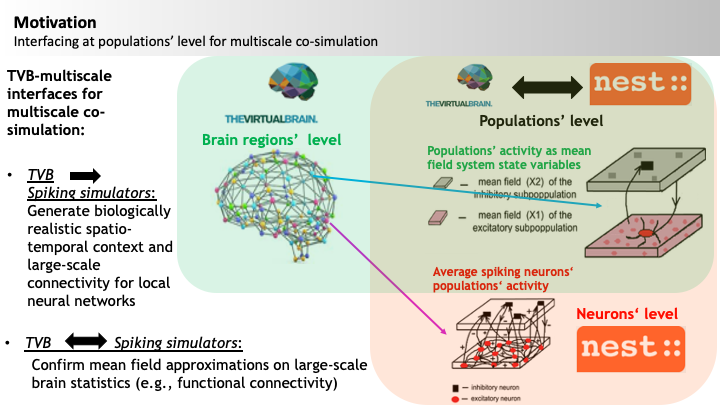

In [2]:
display(Image(filename='./pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

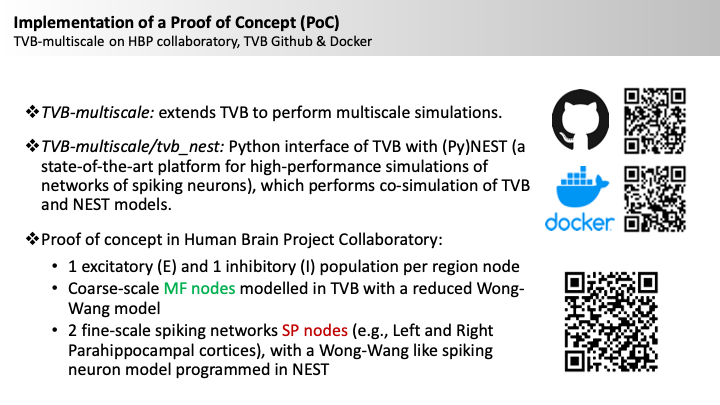

In [3]:
display(Image(filename='./pics/Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation with Wilson & Cowan model

We demonstrate a multiscale simulation <br> of a Wilson & Cowan  model [1] <br> using TVB [1, 2] for brain region modelled at coarse scale, <br> and NEST [3] for regions modelled as <br> networks of spiking neural populations.

## Wilson & Cowan mean field model

See [1] for the equations (4.6a&b) of the model and for the parameters used here (column c in Table 11) for oscillatory regime.

## Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:


$ C_m{\dot{V}_{ni}}^m = - {I_{ni}}^L(t) - {I_{ni}}^{E}(t) - {I_{ni}}^{I}(t) - {I_{ni}}^{E,ext}(t) + I_e(t) $


## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ 1000 * N_E * E(t) $, 
where 1000 stands for the conversion from spikes/ms to spikes/sec. 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Notice that all large-scale input is always scaled with the size of the excitatory population $ N_E $.

## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instant population mean rate that overrides the TVB state variables $E$ and $I$ after low pass filtering via a linear dynamical equation:

$ {\dot{E}_{n}}  = -\frac{1}{\tau_{Ein_{n}}}({E_{n}}(t) - {E_{in_{n}}}(t)) $

$ {\dot{I}_{n}}  = -\frac{1}{\tau_{Iin_{n}}}({I_{n}}(t) - {I_{in_{n}}}(t)) $


where:

$ {E_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n}}{N_E} $

$ {I_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n}}{N_I} $


and $ \tau_{Ein_{n}} = \tau_{Iin_{n}} = 1.0 ms $ by default.

## Simulator loop

### Simulating several (i.e., 10) NEST time steps for every 1 TVB time step for stable integration

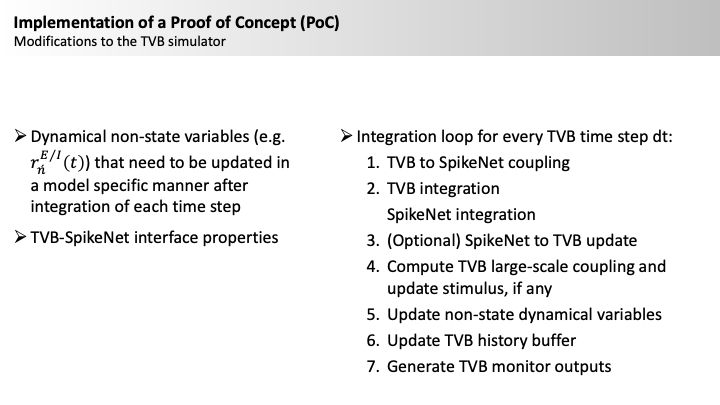

In [4]:
display(Image(filename='./pics/simulator_loop.png',  width=10000, unconfined=False))

# WORKFLOW:

In [5]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale/docs/documented_example_notebook"
config = Config(output_base=os.path.join(home_path, "outputs_WilsonCowan"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

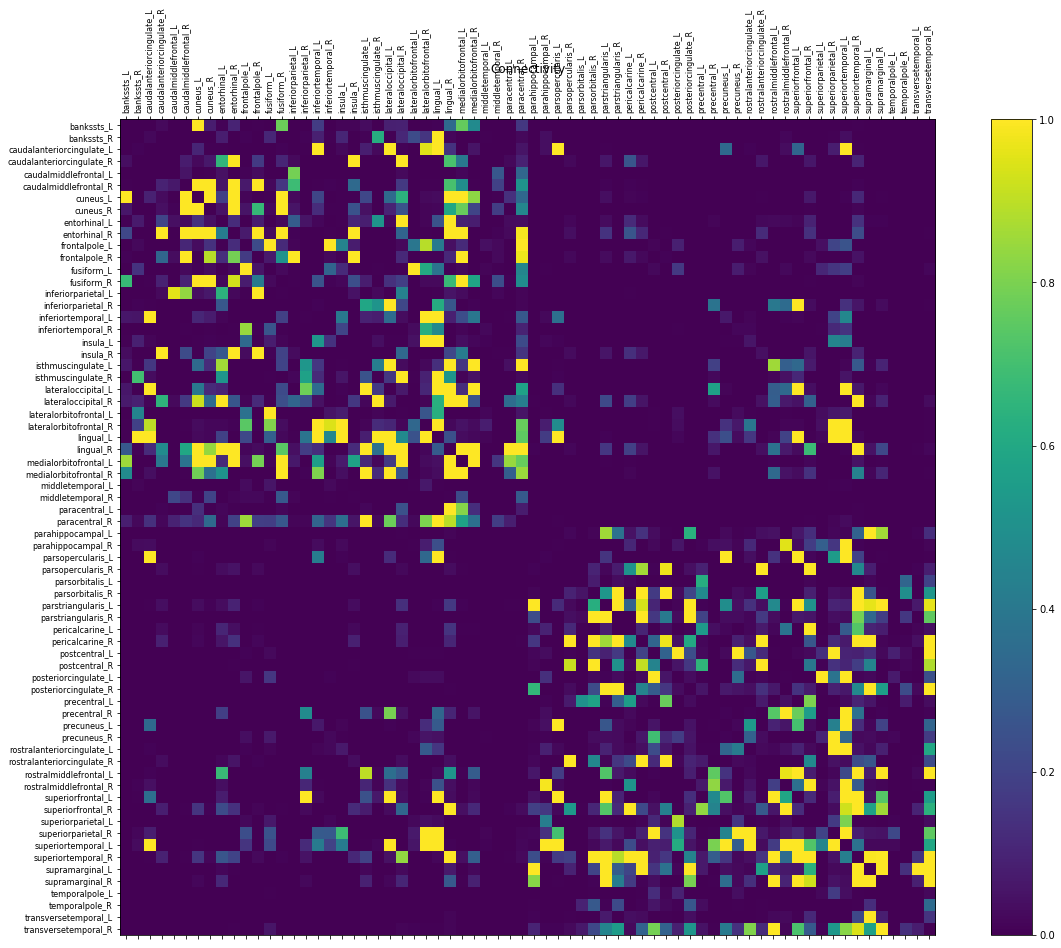

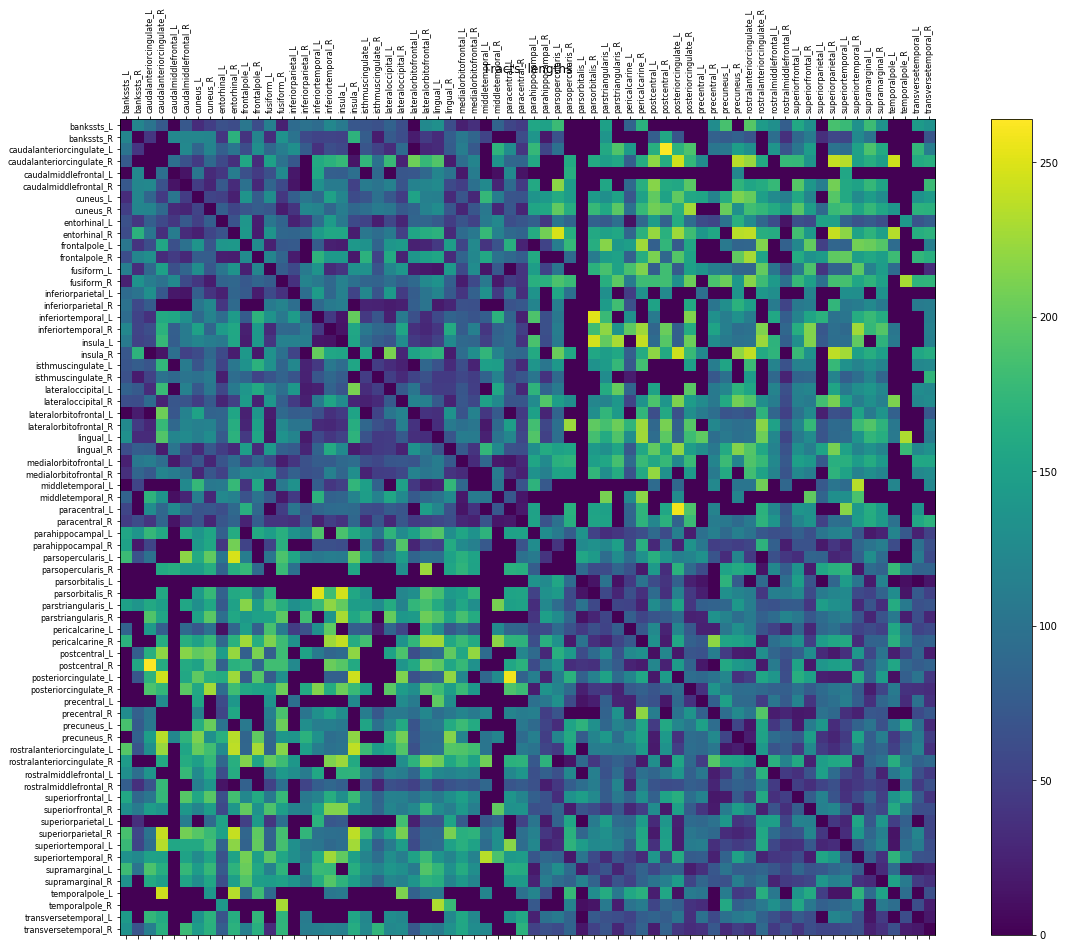

In [6]:
from tvb.simulator.models.wilson_cowan_constraint import WilsonCowan
from tvb_multiscale.core.tvb.simulator_builder import SimulatorBuilder


model_params = {
        "r_e": np.array([0.0]),
        "r_i": np.array([0.0]),
        "k_e": np.array([1.0]),
        "k_i": np.array([1.0]),
        "tau_e": np.array([10.0]),
        "tau_i": np.array([10.0]),
        "c_ee": np.array([10.0]),
        "c_ei": np.array([6.0]),
        "c_ie": np.array([10.0]),
        "c_ii": np.array([1.0]),
        "alpha_e": np.array([1.2]),
        "alpha_i": np.array([2.0]),
        "a_e": np.array([1.0]),
        "a_i": np.array([1.0]),
        "b_e": np.array([0.0]),
        "b_i": np.array([0.0]),
        "c_e": np.array([1.0]),
        "c_i": np.array([1.0]),
        "theta_e": np.array([2.0]),
        "theta_i": np.array([3.5]),
        "P": np.array([0.5]),
        "Q": np.array([0.0])
    }

# ----------------------1. Build a TVB simulator (model, integrator, monitors...)----------------------------------
simulator_builder = SimulatorBuilder()
simulator_builder.connectivity = config.DEFAULT_CONNECTIVITY_ZIP
simulator_builder.model = WilsonCowan

simulator = simulator_builder.build(**model_params)


# Optionally modify the default configuration:

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# from tvb.datatypes.connectivity import Connectivity
# from tvb.simulator.cosimulator import CoSimulator
# from tvb.simulator.integrators import HeunStochastic
# from tvb.simulator.monitors import Raw  # , Bold, EEG
    
# # Load connectivity
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
# # Normalize connectivity weights
# connectivity.weights = connectivity.scaled_weights(mode="region")
# connectivity.weights /= np.percentile(connectivity.weights, 95)
# connectivity.configure()

# # Create a TVB simulator and set all desired inputs
# # (connectivity, model, surface, stimuli etc)
# # We choose all defaults in this example
# simulator = Simulator()
# simulator.model = WilsonCowan(**model_params)

# simulator.connectivity = connectivity

# simulator.integrator = HeunStochastic()
# simulator.integrator.dt = 0.1
# simulator.integrator.noise.nsig = np.array([0.001])

# mon_raw = Raw(period=1.0)  # ms
# simulator.monitors = (mon_raw, )

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [7]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = []  # the indices of fine scale regions modeled with NEST
# We model parahippocampal cortices (left and right) with NEST
for id in range(number_of_regions):
    if simulator.connectivity.region_labels[id].find("hippo") > 0:
        nest_nodes_ids.append(id)
        
from tvb_multiscale.tvb_nest.nest_models.builders.models.wilson_cowan import WilsonCowanBuilder

# Build a NEST network model with the corresponding builder
nest_model_builder = \
    WilsonCowanBuilder(nest_nodes_ids, config=config, 
                       tvb_dt=simulator.integrator.dt,
                       tvb_model=simulator.model.__class__.__name__,
                       tvb_weights=simulator.connectivity.weights[nest_nodes_ids][:, nest_nodes_ids],
                       tvb_delays=simulator.connectivity.delays[nest_nodes_ids][:, nest_nodes_ids],
                       region_labels=simulator.connectivity.region_labels,
                       number_of_regions=simulator.connectivity.number_of_regions,
                       monitor_period=simulator.monitors[0].period,
                       coupling_a=simulator.coupling.a[0].item())


N_E = int(nest_model_builder.population_order * nest_model_builder.scale_e)
N_I = int(nest_model_builder.population_order * nest_model_builder.scale_i)


# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# population_neuron_model = "iaf_cond_alpha"

# nest_model_builder.population_order = 100

# nest_model_builder.scale_e = 1.0
# nest_model_builder.scale_i = 1.0

# N_E = int(nest_model_builder.population_order * nest_model_builder.scale_e)
# N_I = int(nest_model_builder.population_order * nest_model_builder.scale_i)

# nest_model_builder.global_coupling_scaling = simulator.coupling.a[0].item() 

# # When any of the properties model, params and scale below depends on regions,
# # set a handle to a function with
# # arguments (region_index=None) returning the corresponding property

# w_ee = nest_model_builder.tvb_model.c_ee[0].item()
# w_ei = nest_model_builder.tvb_model.c_ei[0].item()
# w_ie = nest_model_builder.tvb_model.c_ie[0].item()
# w_ii = nest_model_builder.tvb_model.c_ii[0].item()


# # Populations' configurations
# # When any of the properties model, params and scale below depends on regions,
# # set a handle to a function with
# # arguments (region_index=None) returning the corresponding property
# nest_model_builder.populations = [
#     {"label": "E", "model": population_neuron_model,
#       "params": {}, "nodes": None,  # None means "all"
#      "scale": nest_model_builder.scale_e},
#     {"label": "I", "model": population_neuron_model,
#      "params": {}, "nodes": None,  # None means "all"
#      "scale": nest_model_builder.scale_i}
#   ]

# # Within region-node connections
# # When any of the properties model, conn_spec, weight, delay, receptor_type below
# # set a handle to a function with
# # arguments (region_index=None) returning the corresponding property

# synapse_model = "static_synapse"
# conn_spec = {"allow_autapses": True, 'allow_multapses': True, 'rule': "all_to_all",
#              "indegree": None, "outdegree": None, "N": None, "p": 0.1}


# within_node_delay = {"distribution": "uniform", 
#                      "low": np.minimum(nest_model_builder.nest_instance.GetKernelStatus("min_delay"), 
#                                        nest_model_builder.default_populations_connection["delay"]), 
#                      "high": np.maximum(nest_model_builder.tvb_dt, 
#                                         2*nest_model_builder.default_populations_connection["delay"])}

# nest_model_builder.populations_connections = [
#      #              ->
#     {"source": "E", "target": "E",  # E -> E This is a self-connection for population "E"
#      "synapse_model": synapse_model, "conn_spec": conn_spec,
#      "weight": {"distribution": "normal", "mu": w_ee, "sigma": 0.1*w_ee},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None},  # None means apply to all
#     {"source": "E", "target": "I",  # E -> I
#      "synapse_model": synapse_model, "conn_spec": conn_spec,
#      "weight": {"distribution": "normal", "mu": w_ei, "sigma": 0.1*w_ei},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None},  # None means apply to all
#     {"source": "I", "target": "E",  # I -> E
#      "synapse_model": synapse_model,
#      "conn_spec": conn_spec, "weight": {"distribution": "normal", "mu": -w_ie, "sigma": 0.1*w_ie},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None},  # None means apply to all
#     {"source": "I", "target": "I",  # I -> I This is a self-connection for population "I"
#      "synapse_model": synapse_model, "conn_spec": conn_spec,
#      "weight": {"distribution": "normal", "mu": -w_ii, "sigma": 0.1*w_ii},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None}  # None means apply to all
#     ]


# # Among/Between region-node connections
# # Given that only the AMPA population of one region-node couples to
# # all populations of another region-node,
# # we need only one connection type
        
# # When any of the properties model, conn_spec, weight, delay, receptor_type below
# # depends on regions, set a handle to a function with
# # arguments (source_region_index=None, target_region_index=None)

# from tvb_multiscale.core.spiking_models.builders.templates \
#     import random_normal_tvb_weight, random_uniform_tvb_delay
    
# # Total excitatory spikes of one region node will be distributed to
# nest_model_builder.nodes_connections = [
#     #              ->
#     {"source": "E", "target": ["E"],
#      "synapse_model": synapse_model, "conn_spec": conn_spec,
#      "weight": lambda source_node, target_node: 
#                  random_normal_tvb_weight(source_node, target_node, nest_model_builder.tvb_weights, 
#                                           scale=nest_model_builder.global_coupling_scaling, sigma=0.1),
#      "delay": lambda source_node, target_node: \
#                  random_uniform_tvb_delay(source_node, target_node, nest_model_builder.tvb_delays, 
#                                           low=nest_model_builder.tvb_dt, 
#                                           high=2*nest_model_builder.tvb_dt, 
#                                           sigma=0.1),  
#      "receptor_type": 0,
#      "source_nodes": None, "target_nodes": None}  # None means apply to all
#     ]

# # Creating  devices to be able to observe NEST activity:

# nest_model_builder.output_devices = []

# connections = OrderedDict({})
# #          label <- target population
# connections["E"] = "E"
# connections["I"] = "I"
# nest_model_builder.output_devices.append(
#     {"model": "spike_recorder", "params": {"record_to": "memory"},
#      "connections": connections, "nodes": None})  # None means apply to "all"

# # Labels have to be different

# connections = OrderedDict({})
# #               label    <- target population
# connections["Excitatory"] = "E"
# connections["Inhibitory"] = "I"
# params = {'record_from': ["V_m"], "interval": 1.0, "record_to": "memory"}
# nest_model_builder.output_devices.append(
#     {"model": "multimeter", "params": params,
#      "connections": connections, "nodes": None})  # None means apply to all
    

# # Create a spike stimulus input device
# nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": 6400.0, "origin": 0.0, "start": 0.1},  # "stop": 100.0
#      "connections": {"Stimulus": ["E"]}, 
#      "nodes": None,         # None means apply to all
#      "weights": {"distribution": "normal", "mu": 1.0, "sigma": 0.1}, 
#      "delays": {"distribution": "uniform", 
#                 "low": nest_model_builder.tvb_dt, 
#                 "high": 2*nest_model_builder.tvb_dt},
#      "receptor_type": 0}
#                                   ]  #

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

nest_network = nest_model_builder.build_spiking_network()


2020-11-04 15:33:00,708 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-11-04 15:33:00,708 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-11-04 15:33:00,713 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-11-04 15:33:00,713 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-11-04 15:33:00,716 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-11-04 15:33:00,716 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-11-04 15:33:00,721 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-11-04 15:33:00,721 - INFO - tvb_multiscale.t

2020-11-04 15:33:00,999 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E created!
2020-11-04 15:33:00,999 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E created!
2020-11-04 15:33:01,063 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for I created!
2020-11-04 15:33:01,063 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for I created!
2020-11-04 15:33:01,128 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model multimeter for Excitatory created!
2020-11-04 15:33:01,128 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multi

In [8]:
print(nest_network.print_str(connectivity=True))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['parahippocampal_L', 'parahippocampal_R']
Regions' nodes:


----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: parahippocampal_L
Populations ['E', 'I']:

----------------------------------------------------------------------------------------------------

NESTPopulation - Label: E 
model: iaf_cond_alpha
100 neurons: 1...100
parameters: {'archiver_length': 0, 'beta_Ca': array([0.001]), 'C_m': array([250.]), 'Ca': array([0.]), 'dg_ex': array([0.]), 'dg_in': array([0.]), 'E_L':

## 3. Build the TVB-NEST interface

In [9]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.wilson_cowan import \
    WilsonCowanBuilder as InterfaceWilsonCowanBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    InterfaceWilsonCowanBuilder(simulator, nest_network, nest_nodes_ids, 
                                exclusive_nodes=True, populations_sizes=[N_E, N_I])

tvb_to_nest_mode="rate"
nest_to_tvb=True

# Using all default parameters for this example

# or...


# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# from tvb_multiscale.core.spiking_models.builders.templates \
#     import random_normal_tvb_weight, random_uniform_tvb_delay


# # TVB -> NEST


# # --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------


# if tvb_to_nest_mode == "rate":
#     # Mean spike rates are applied in parallel to all target neurons

#     tvb_nest_builder.tvb_to_spikeNet_interfaces = [
#         {"model": "inhomogeneous_poisson_generator",
#          "params": {"allow_offgrid_times": False},
#     # # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
#          "interface_weights": 1.0 * N_E, 
#     # Applied outside NEST for each interface device
#     # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#         "weights": lambda tvb_node_id, nest_node_id: \
#                             random_normal_tvb_weight(tvb_node_id, nest_node_id, tvb_nest_builder.tvb_weights, 
#                                                      scale=tvb_nest_builder.global_coupling_scaling, sigma=0.1),
#         "delays": lambda tvb_node_id, nest_node_id: \
#                         random_uniform_tvb_delay(tvb_node_id, nest_node_id, tvb_nest_builder.tvb_delays,
#                                                  low=tvb_nest_builder.tvb_dt, 
#                                                  high=2*tvb_nest_builder.tvb_dt, 
#                                                  sigma=0.1),
#         "receptor_type": 0,
#         # --------------------------------------------------------------------------------------------------------------
#         #             TVB sv -> NEST population
#         "connections": {"E": ["E"]},
#         "source_nodes": None, "target_nodes": None}]  # None means all here

    
# if nest_to_tvb:
#     # NEST -> TVB:
#     # Use S_e and S_i instead of r_e and r_i
#     # for transmitting to the TVB state variables directly
#     connections = OrderedDict()
#     #            TVB <- NEST
#     connections["Ein"] = ["E"]
#     connections["Iin"] = ["I"]
#     tvb_nest_builder.spikeNet_to_tvb_interfaces = [
#         {"model": "spike_detector", "params": {},
#     # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
#          "interface_weights": 1.0, "delays": 0.0,
#     # -----------------------------------------------------------------------------------------------------------------
#          "connections": connections, "nodes": None}]  # None means all here

    
# # WilsonCowan model state variables are bounded in [0, 1],
# # and have to be converted in Hz as poisson_generator assumes in NEST:
# tvb_nest_builder.w_tvb_to_spike_rate = 1000.0
# # We return from a NEST spike_detector the ratio number_of_population_spikes / number_of_population_neurons
# # for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# # as long as a neuron cannot fire twice during a TVB time step, i.e.,
# # as long as the TVB time step (usually 0.001 to 0.1 ms)
# # is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
# tvb_nest_builder.w_spikes_to_tvb = 1.0

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

2020-11-04 15:33:18,324 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.WilsonCowan'> created!
2020-11-04 15:33:18,324 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.WilsonCowan'> created!
2020-11-04 15:33:18,327 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.WilsonCowan'> created!
2020-11-04 15:33:18,327 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.WilsonCowan'> created!
2020-11-04 15:33:18,341 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for E created!
2020-11-04 15:33:18,341 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for E created!
2020-11-04 15:33:2

In [10]:
print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
WilsonCowan TVB-NEST Interface


----------------------------------------------------------------------------------------------------


TVB to spikeNet interfaces:

----------------------------------------------------------------------------------------------------

Index: E_0

TVBtoNESTInhomogeneousPoissonGeneratorInterface
Name: E, TVB state variable indice: 0, 
Interface weights: [100.0]
Target NEST Nodes indices:
0...33, 36...67 
TVBtoNESTInhomogeneousPoissonGeneratorInterface - Name: E, Model: inhomogeneous_poisson_generator,
Devices:
----------------------------------------------------------------------------------------------------

NESTInhomogeneousPoissonGenerator - Model: inh

## 4. Configure simulator, simulate, gather results

In [11]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
simulation_length = 110.0 # 1100 for a more meaningful simulation
transient = simulation_length/11
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))

2020-11-04 15:33:21,024 - INFO - tvb.simulator.cosimulator - Region simulation with 68 ROI nodes
2020-11-04 15:33:21,030 - INFO - tvb.simulator.cosimulator - Memory requirement estimate: simulation will need about 4.5 MB
2020-11-04 15:33:21,033 - INFO - tvb.simulator.cosimulator - Preparing initial history of shape (880, 4, 68, 1) using model.initial()
2020-11-04 15:33:21,088 - INFO - tvb.simulator.cosimulator - Final initial history shape is (880, 4, 68, 1)
2020-11-04 15:33:21,093 - INFO - tvb.simulator.cosimulator - Memory requirement census: simulation will need about 1.8 MB
2020-11-04 15:33:21,095 - INFO - tvb.simulator.cosimulator - Simulation runtime should be about 1.966 seconds
2020-11-04 15:33:21,097 - INFO - tvb.simulator.cosimulator - Calculating storage requirement for ...
2020-11-04 15:33:21,098 - INFO - tvb.simulator.cosimulator - Calculated storage requirement for simulation: 2692800 
...10.0% done in 1.5 sec- INFO - tvb.simulator.cosimulator - 
...20.0% done in 3.0 sec-

In [12]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()


## 5. Plot results and write them to HDF5 files

In [13]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = True  
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [14]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

# Remove transient, if any
if transient:
    source_ts = source_ts[transient:]
    exclude_times = [0.0, transient]
else:
    exclude_times = []
t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

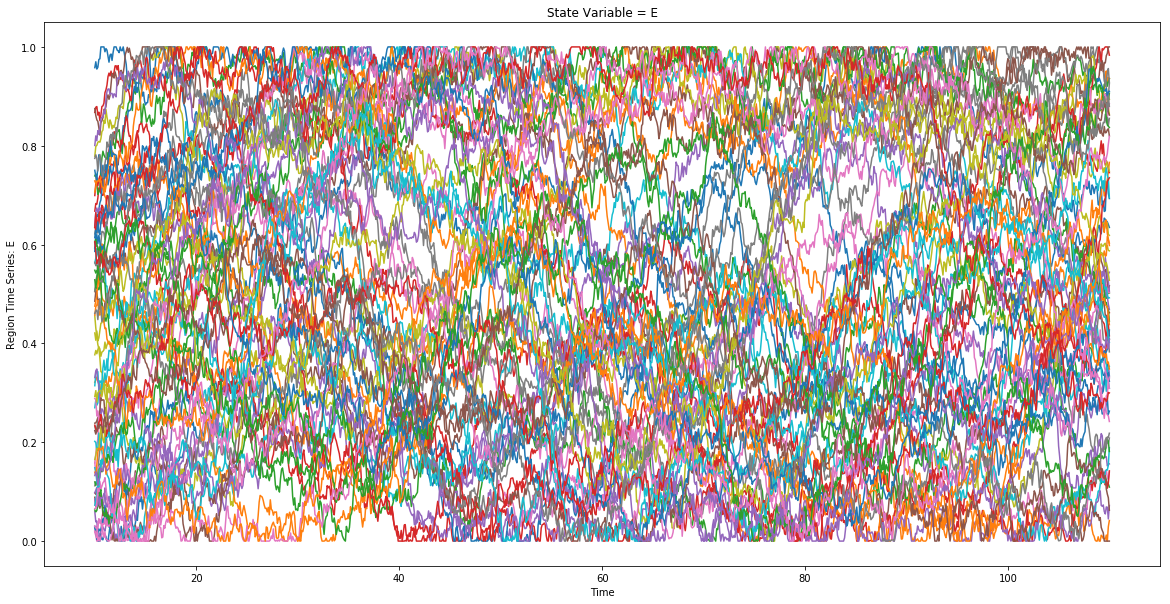

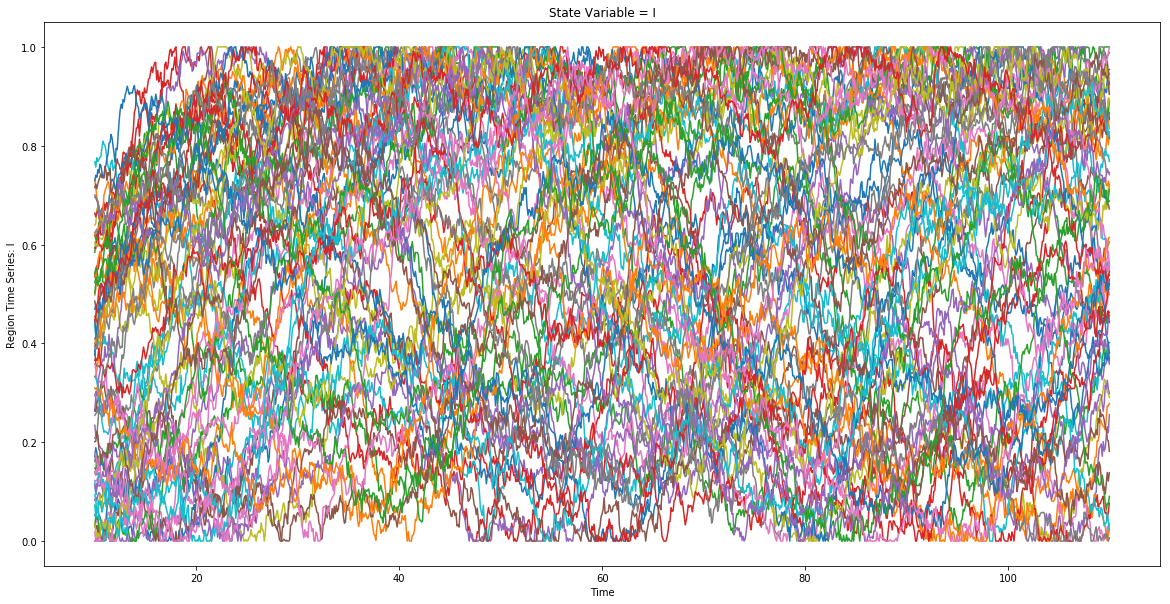

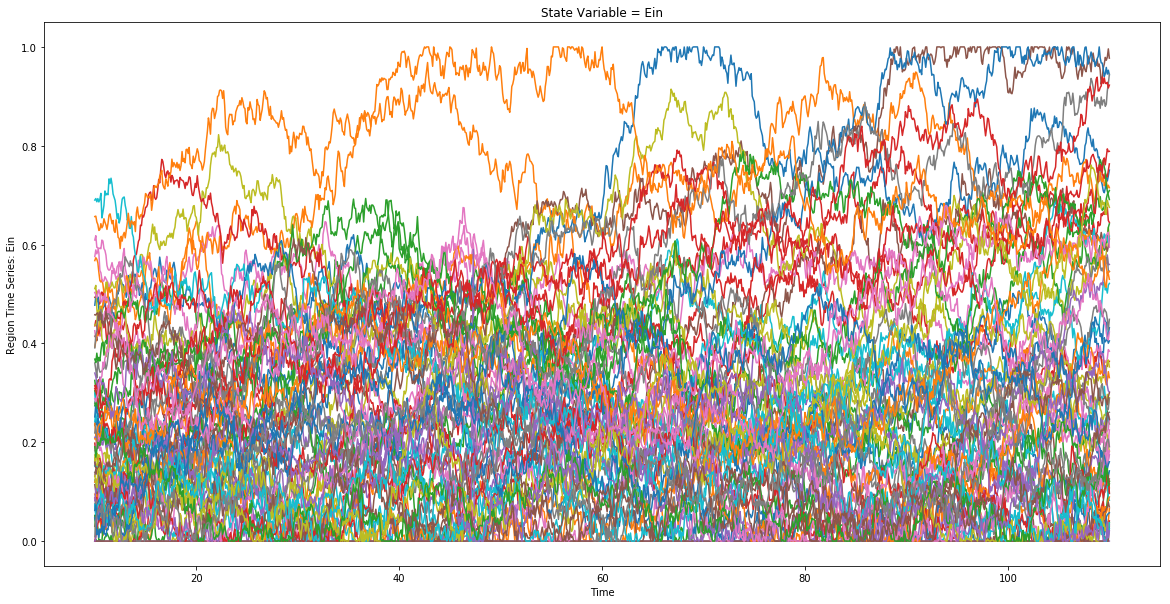

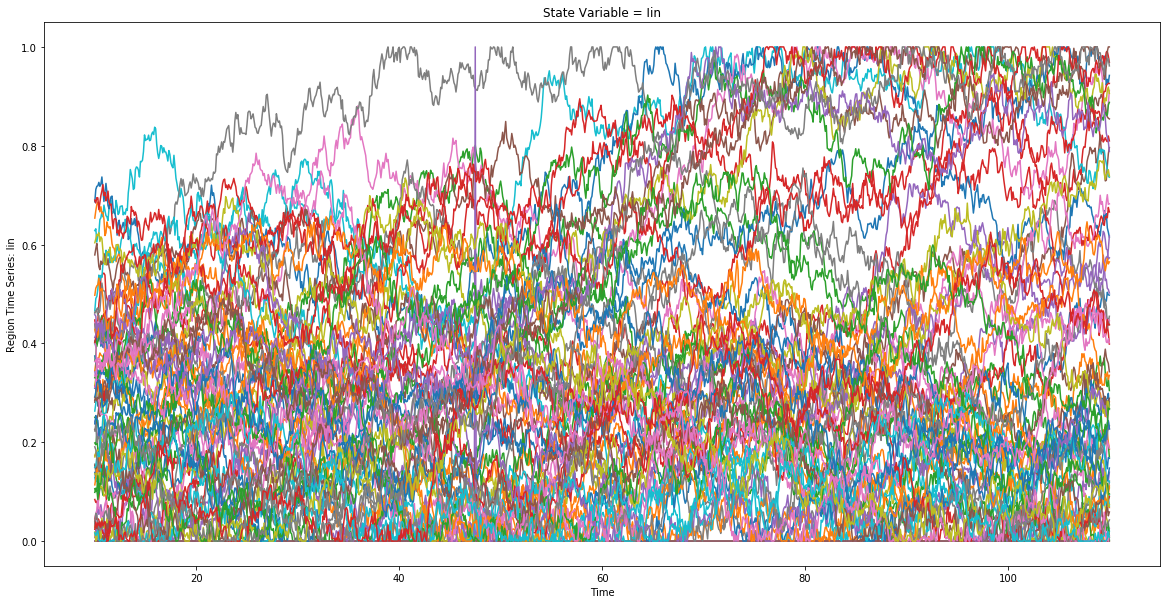

In [15]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

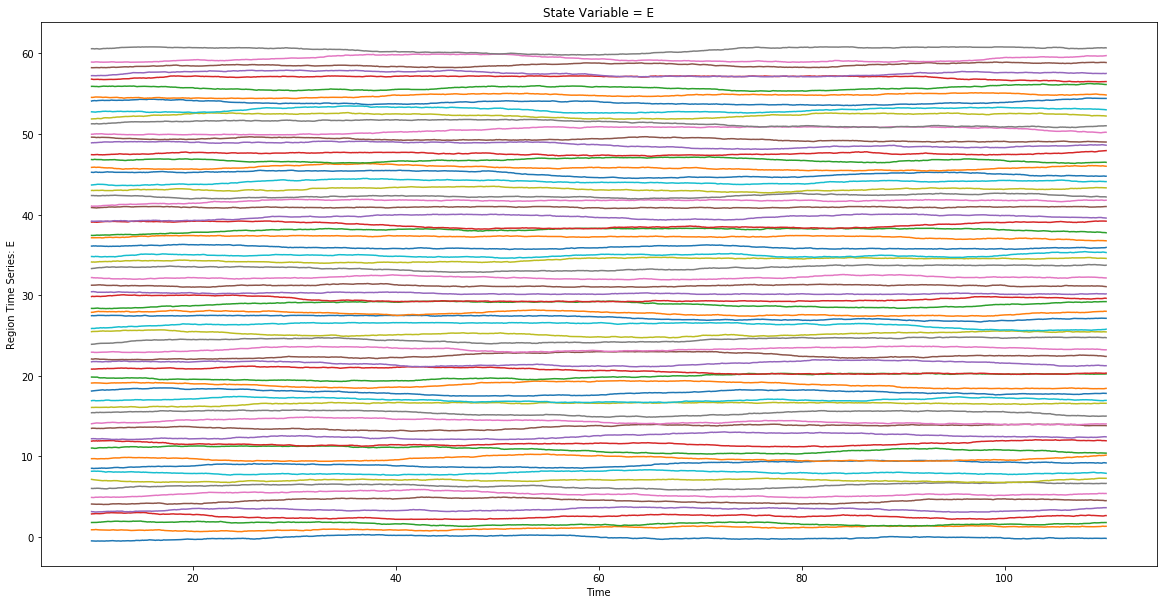

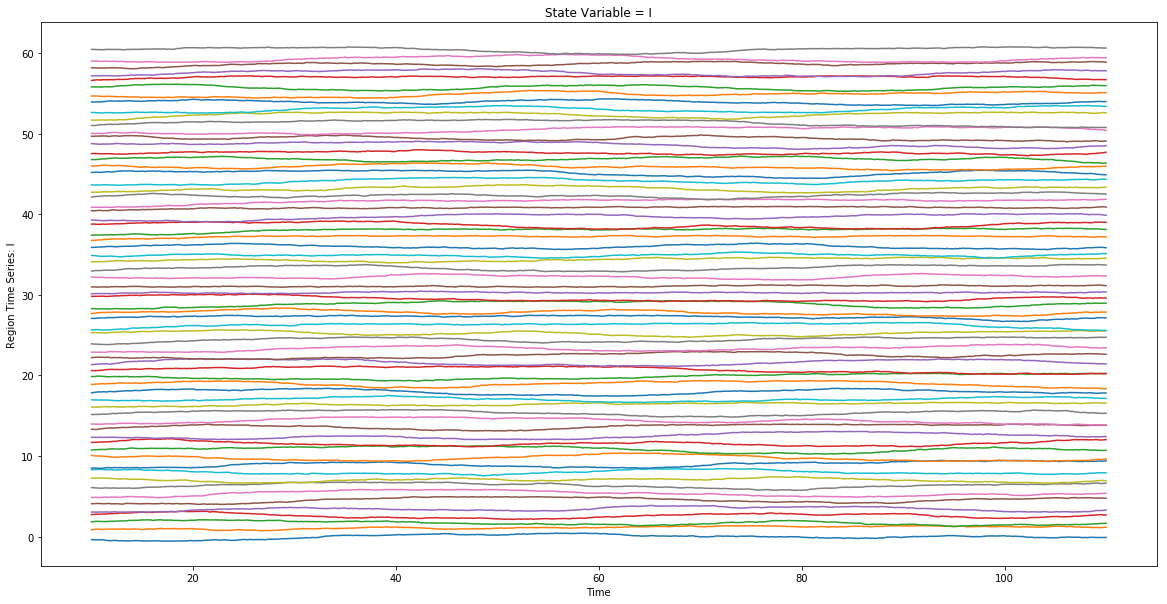

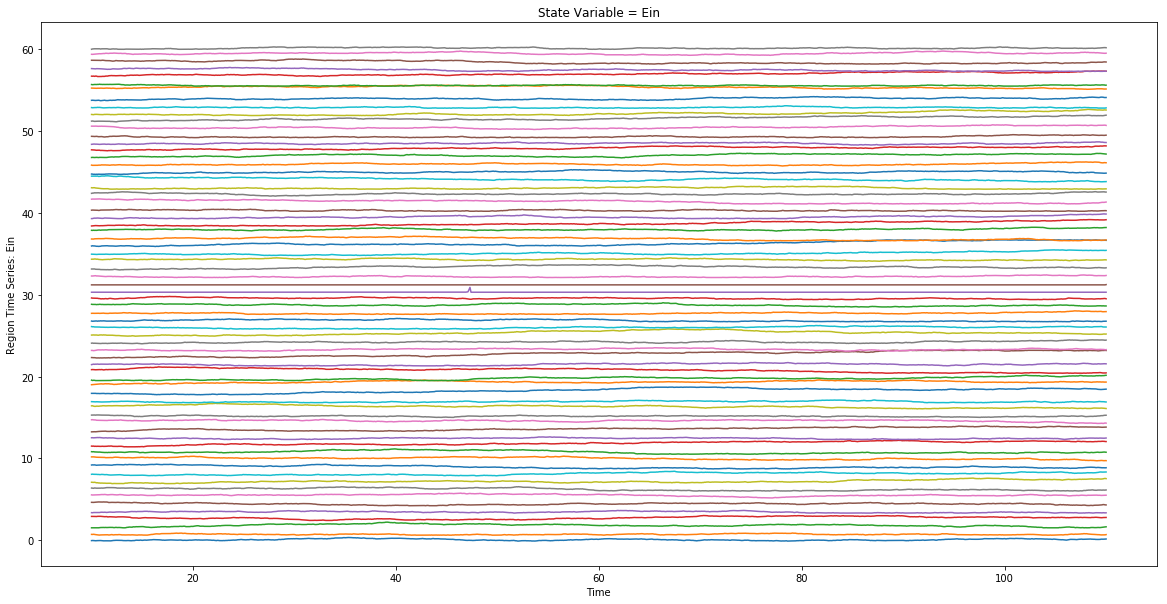

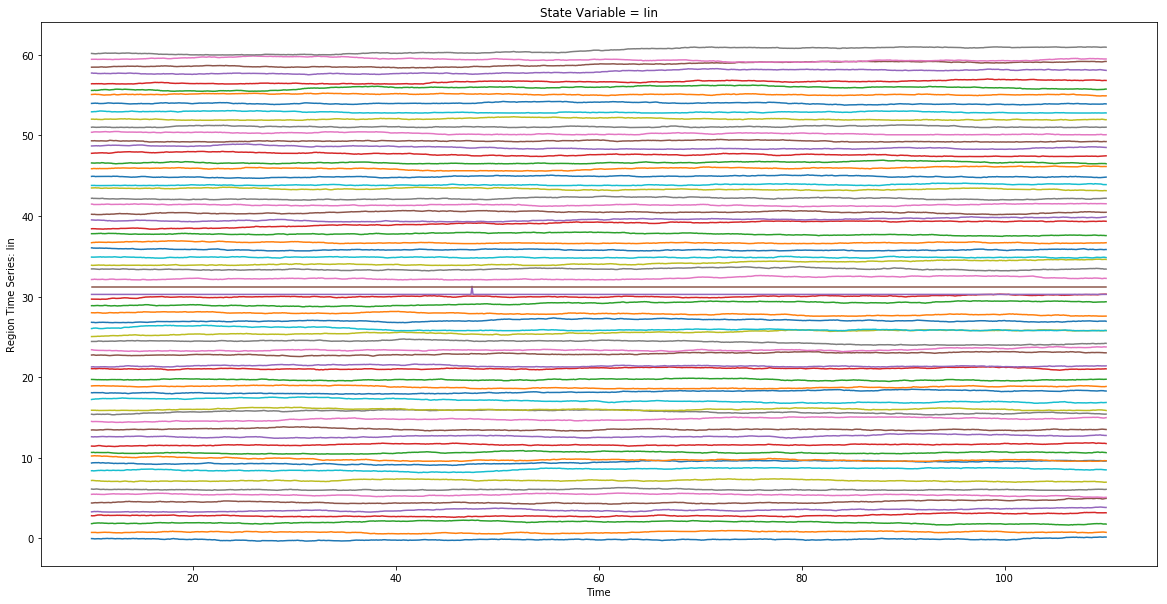

In [16]:
# TVB time series raster plot:
if source_ts.number_of_labels > 9:
    source_ts.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

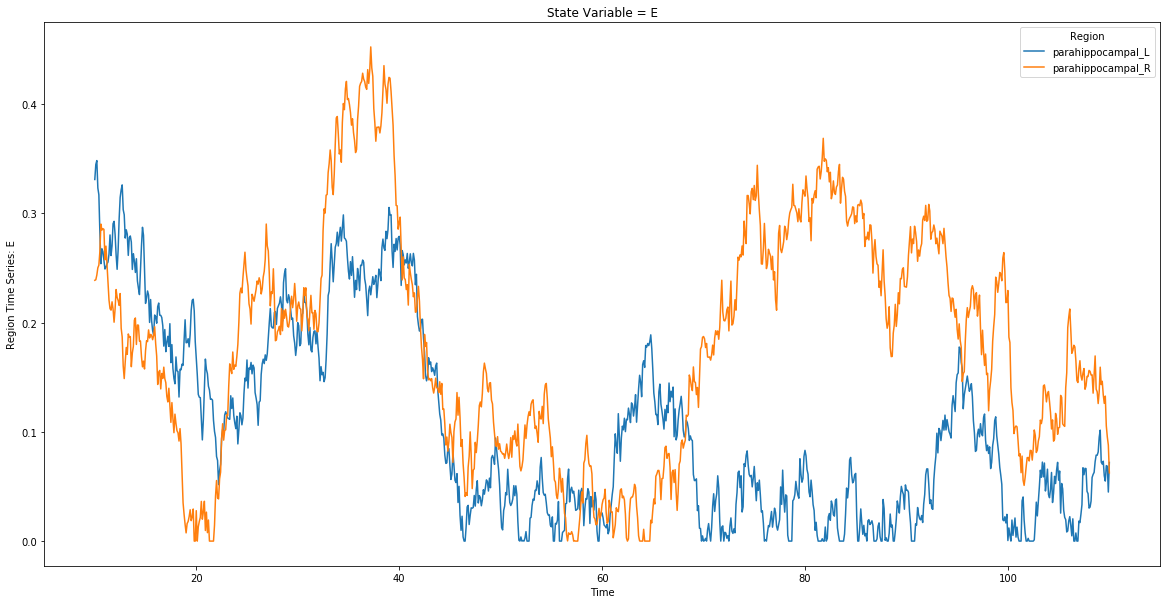

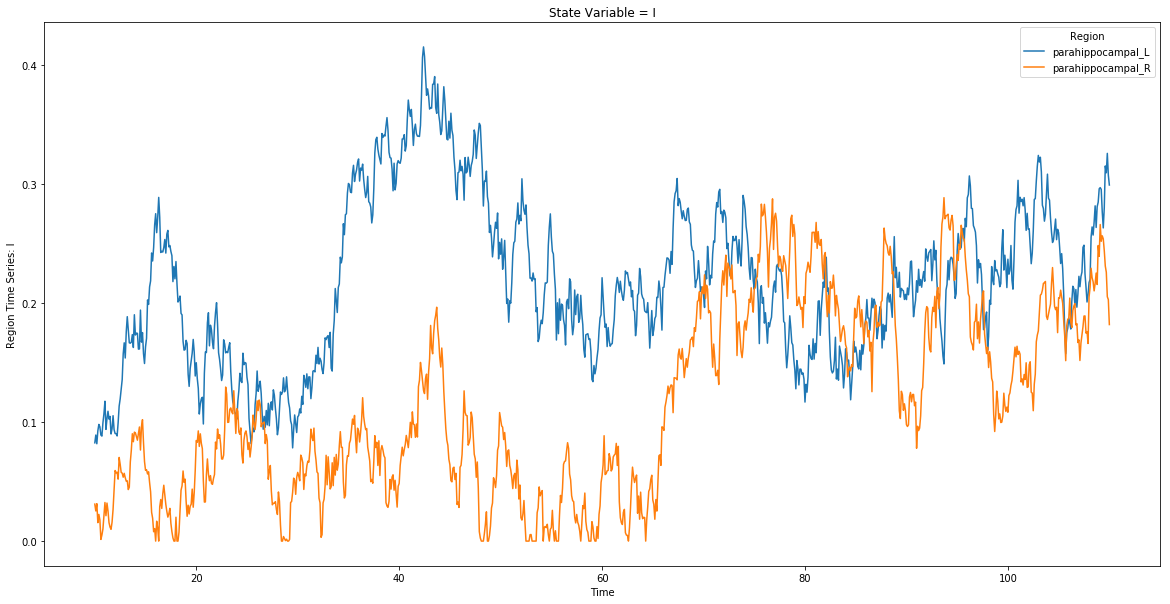

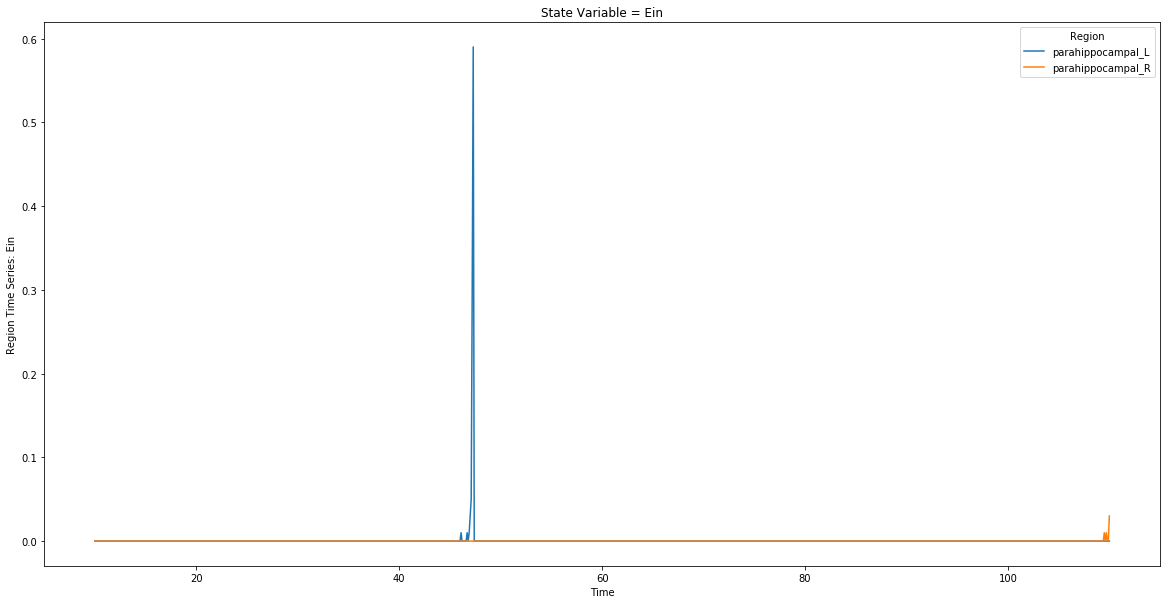

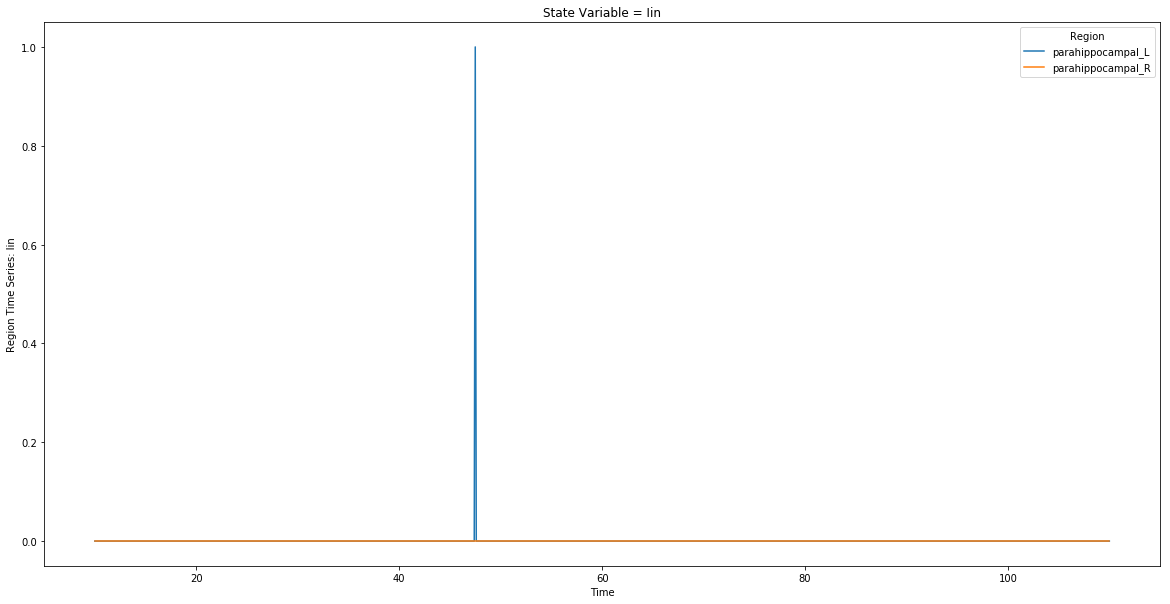

In [17]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                               figname="Spiking nodes TVB Time Series");

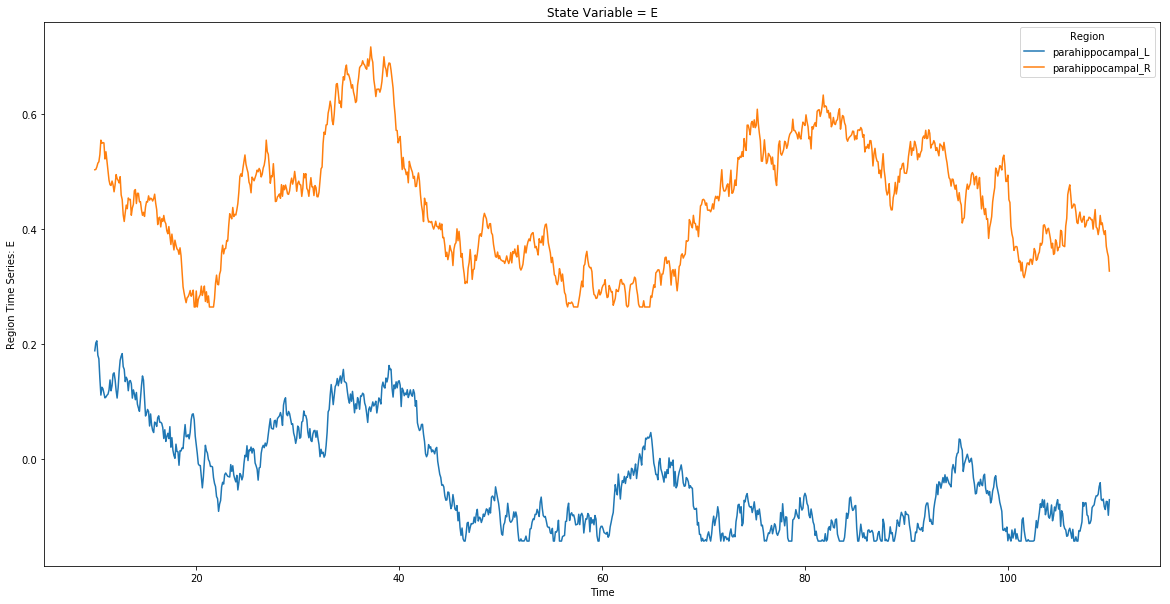

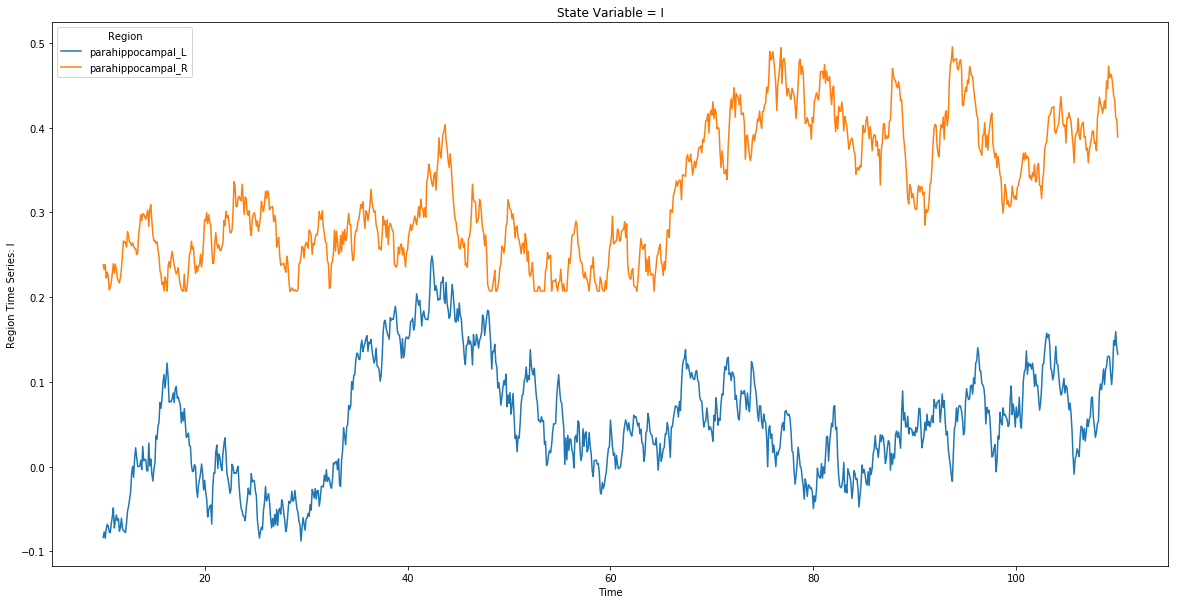

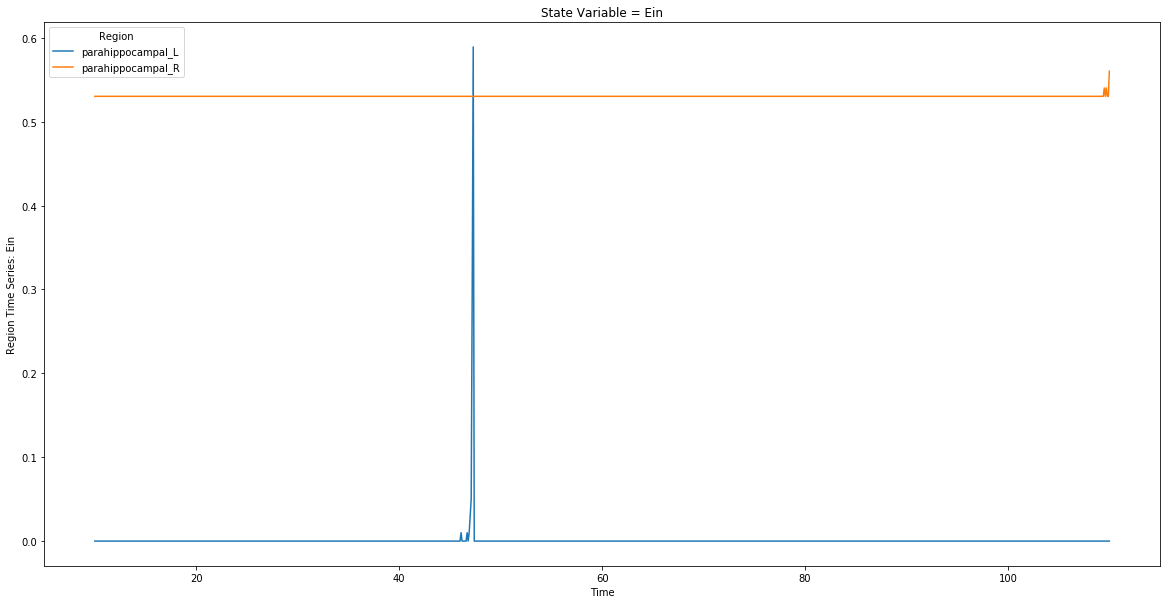

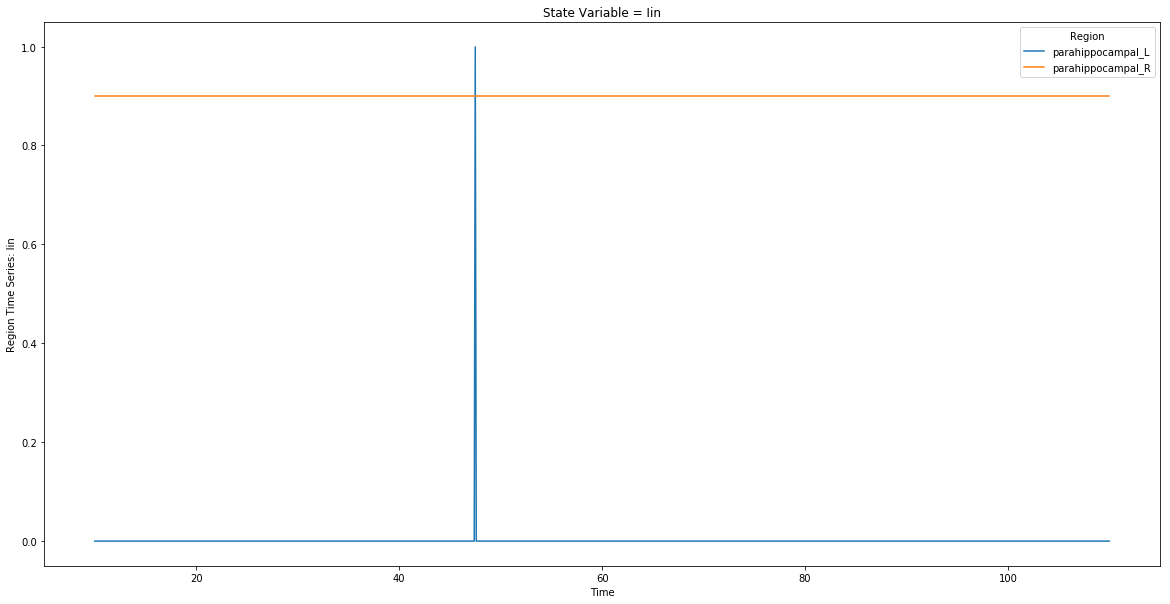

In [18]:
# Focus on the nodes modelled in NEST: raster plot
source_ts_nest.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                           figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [19]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [20]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=source_ts.time[0], end_time=source_ts.time[-1], 
                           period=simulator.monitors[0].period,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [21]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:495: UserWarning:Binning discarded 206 last spike(s) in the input spiketrain.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:510: UserWarning:Detected empty spike trains (rows) in the binned_spiketrain.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:517: RuntimeWarning:invalid value encountered in true_divide


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 2, Region: 2)>
array([[0.01  , 0.0005],
       [0.01  , 0.    ]])
Coordinates:
  * Region      (Region) object 'parahippocampal_L' 'parahippocampal_R'
  * Population  (Population) object 'E' 'I'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 2, Population_j: 2, Region_i: 2, Region_j: 2)>
array([[[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]],


       [[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]]])
Coordinates:
  * Population_i  (Population_i) object 'E' 'I'
  * Region_i      (Region_i) object 'parahippocampal_L' 'parahippocampal_R'
  * Population_j  (Population_j) object 'E' 'I'
  * Region_j      (Region_j) object 'parahippocampal_L' 'parahippocampal_R'
2020-11-04 15:33:49,055 - ERROR - tvb.contrib.scripts.datatypes.time_series_xarray - Cannot access index 3 of labels ordering: ('Time', 'Population', 'Region')!
2020-11-04 15:33:49,

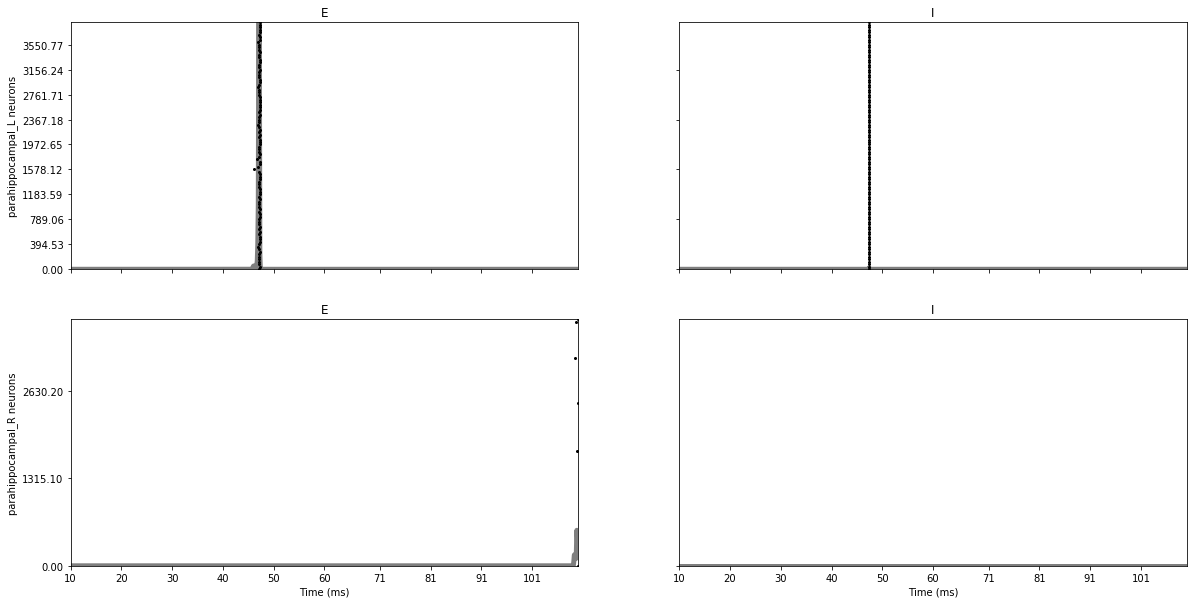

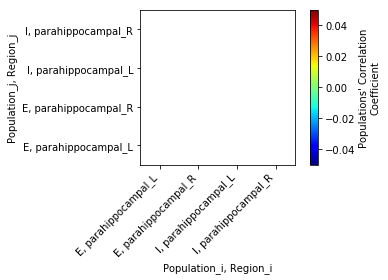

In [22]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"], figsize=FIGSIZE)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [23]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2020-11-04 15:33:49,803 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_WilsonCowan/res/Spikes.h5
2020-11-04 15:33:49,803 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_WilsonCowan/res/Spikes.h5
2020-11-04 15:33:49,821 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E/parahippocampal_L" (2 members)> dataset <class 'numpy.ndarray'> senders:
[ 41  45  74  10  59  92  42  73  87  71  11  17   1  50  56  64   4   9
  26  30  34  36  54  61  79  82   5   7  15  20  28  46  48  49  62  75
  78  80  86  89  95   3   6  19  21  24  27  35  40  58  60  72  83  90
  91   2  12  13  23  29  31  33  37  44  55  57  63  65  66  69  70  77
  81  84  88  93  97   8  18  22  25  32  38  39  43  47  51  52  53  67
  68  76  85  94  98  99 100  14  16  96] !

2020-11-04 1

2020-11-04 15:33:49,903 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I/parahippocampal_R" (2 members)> dataset <class 'numpy.ndarray'> times:
[] !

2020-11-04 15:33:49,923 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written to file: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_WilsonCowan/res/Spikes.h5
2020-11-04 15:33:49,923 - INFO - tvb_multiscale.core.io.h5_writer - dict has been written to file: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_WilsonCowan/res/Spikes.h5
2020-11-04 15:33:49,928 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_WilsonCowan/res/Mean Populations' Spikes' Rates.h5
2020-11-04 15:33:49,928 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_WilsonCowan/r

2020-11-04 15:33:50,213 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2020-11-04 15:33:50,213 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2020-11-04 15:33:50,219 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> data:
['E' 'I'] !

2020-11-04 15:33:50,219 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> data:
['E' 'I'] !

2020-11-04 15:33:50,228 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-11-04 15:33:50,228 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class

### Get  SpikingNetwork mean field variable time series and plot them

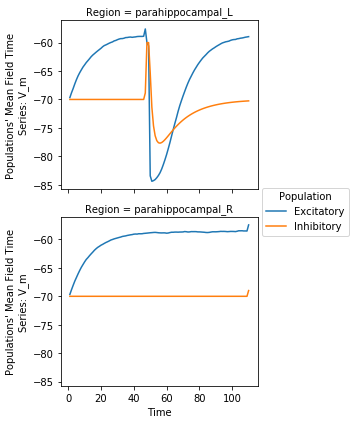

In [24]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
        spikeNet_ts = None
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True)
        if mean_field_ts.shape[2] > 3:
            mean_field_ts.plot_raster(plotter_config=plotter.config, per_variable=True,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [25]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

<Figure size 432x288 with 0 Axes>

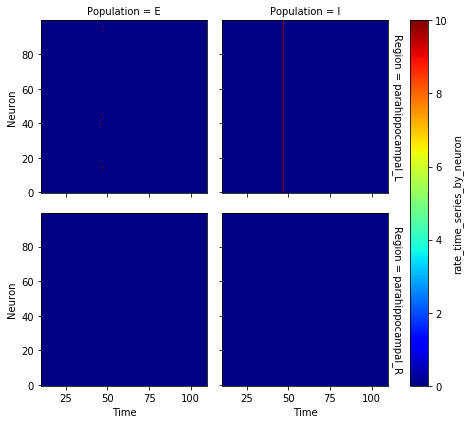

In [26]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

<Figure size 432x288 with 0 Axes>

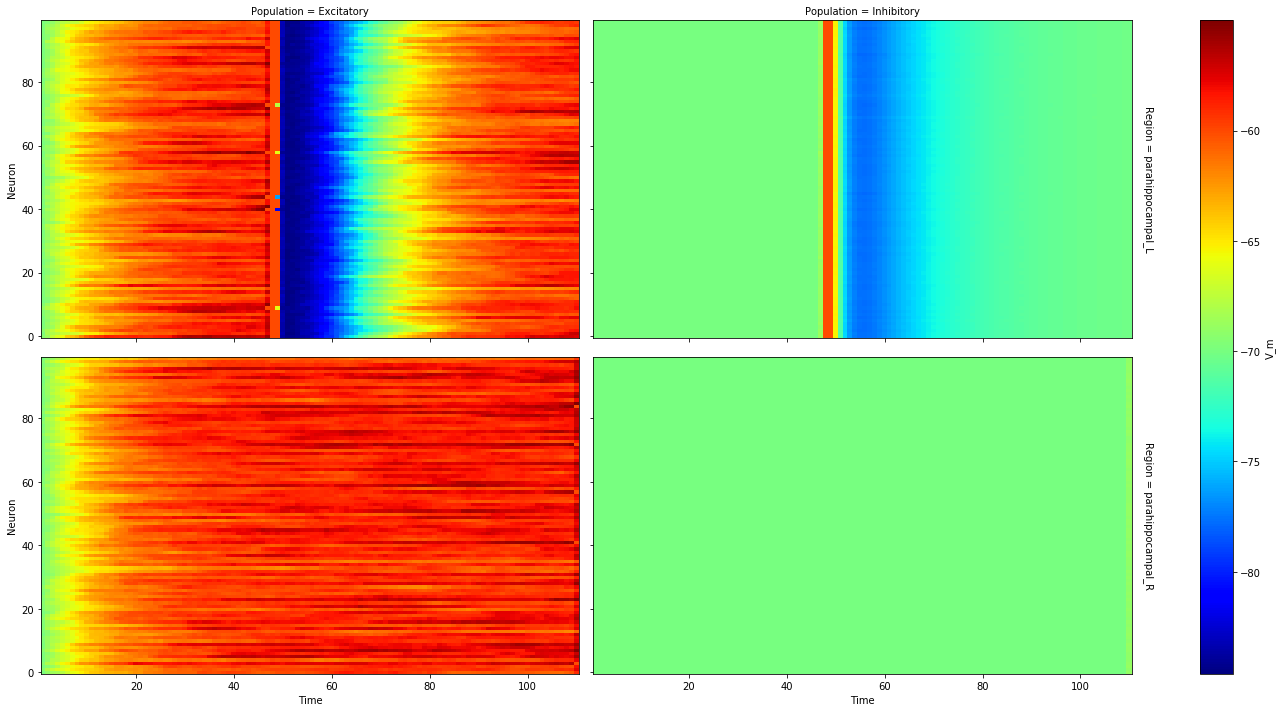

In [30]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>